In [39]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
ROOT.gROOT.ProcessLine("gErrorIgnoreLevel = 3001;"); # suppress ROOT messages
ROOT.disableJSVis()
ROOT.gStyle.SetOptStat(0)
# ROOT.gROOT.ProcessLine(".x ~/env/MJDClintPlotStyle.C");

# results:

def npTH1D(hist):
    bins = hist.GetNbinsX()
    xArr, yArr = np.zeros(bins),np.zeros(bins)
    yArr = np.zeros(bins)
    for i in range(bins): 
        xArr[i] = hist.GetXaxis().GetBinCenter(i)
        yArr[i] = hist.GetBinContent(i)    
    return xArr,yArr

def integFunc(arr):
    integ = np.zeros(len(arr))
    sum = 0
    for i in range(0,len(arr)):
        sum+=arr[i]
        integ[i] = sum
    return integ

def GetIntegralPoints(hist):
    x_h0, y_h0 = npTH1D(hist)
    int_h0 = integFunc(y_h0)
    
    idx99 = np.where(int_h0 > 0.99)
    idx95 = np.where(int_h0 > 0.95)
    idx90 = np.where(int_h0 > 0.90)
    idx01 = np.where(int_h0 > 0.01)
    idx05 = np.where(int_h0 > 0.05)
    idx10 = np.where(int_h0 > 0.10)
    idx15 = np.where(int_h0 > 0.15)
    
    val99 = x_h0[idx99][0]
    val95 = x_h0[idx95][0]
    val90 = x_h0[idx90][0]
    val01 = x_h0[idx01][0]
    val05 = x_h0[idx05][0]
    val10 = x_h0[idx10][0]
    val15 = x_h0[idx15][0]
    return val01,val05,val10,val15,val90,val95,val99

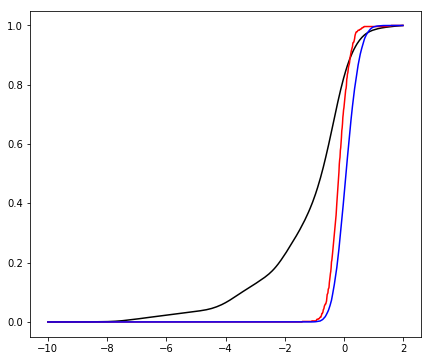


****************************************
Minimizer is Linear
Chi2                      =  6.20515e+09
NDf                       =        40723
p0                        =  -0.00210214   +/-   0.00780509  
p1                        =    -0.178262   +/-   0.000515147 
raw 99: 1.196  95: 0.524  90: 0.248  01: -6.988  05: -4.324
bg 99: 0.596  95: 0.356  90: 0.224  01: -0.868  05: -0.664
ext 99: 0.920  95: 0.680  90: 0.548  01: -0.700  05: -0.484


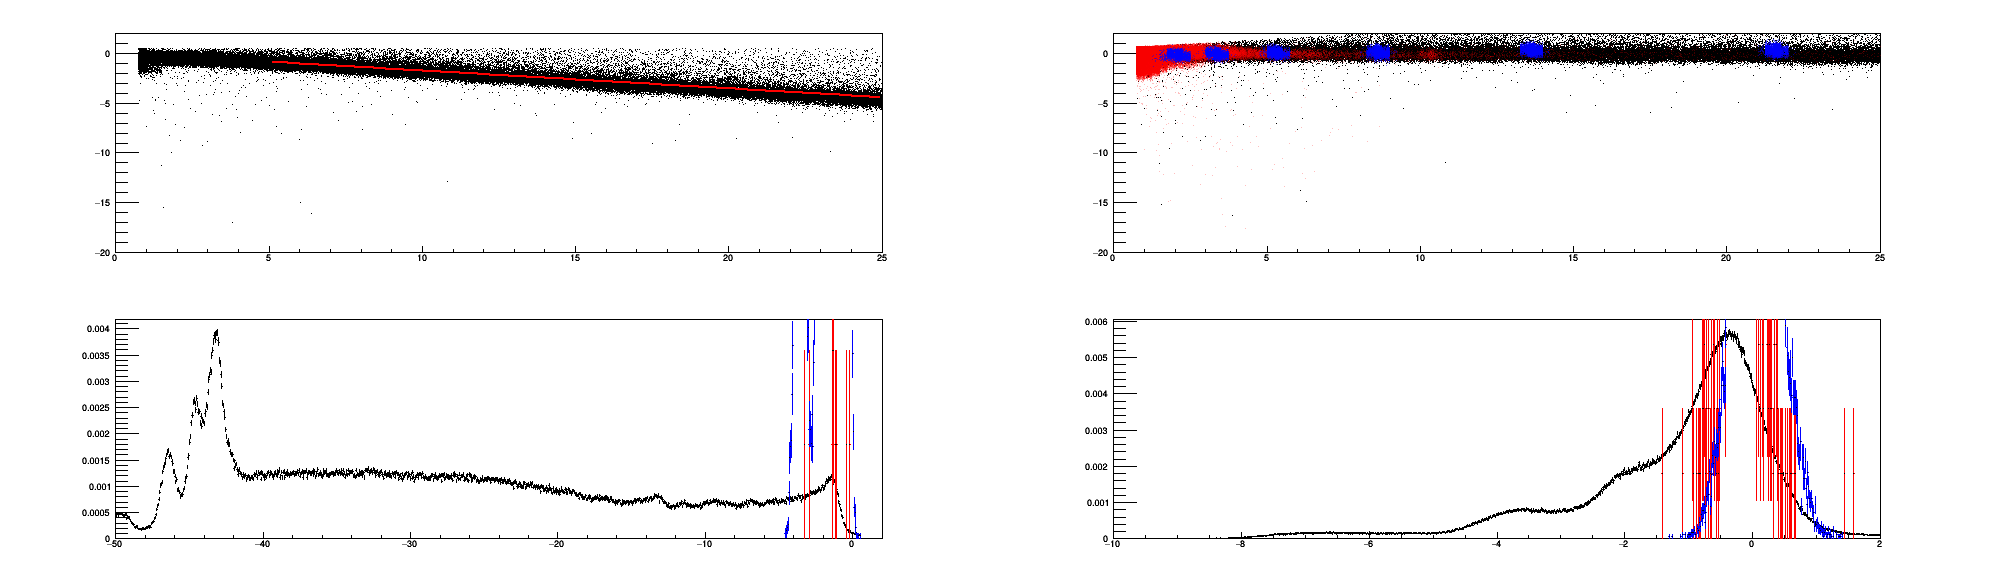

In [45]:
ds = 0
bins, lower, upper = 1000,-10,2
bins2, lower2, upper2 = 1000,-50,2

f1 = ROOT.TFile("~/project/lat/latSkimDS%d_0_0.root"%ds)
theCut = f1.Get("theCut").GetTitle()
bgCut = "&& isNat && trapENFCal > 9.8 && trapENFCal < 10.8" # Integrating over 10.4 keV peak
ExtCut = "channel == 624"
calib = ROOT.TChain("skimTree"); calib.Add("~/project/cal-lat/latSkimDS%d*.root"%ds)
bg = ROOT.TChain("skimTree"); bg.Add("~/project/lat/latSkimDS%d*.root"%ds)
Ext = ROOT.TChain("mjdTree"); Ext.Add("~/project/ForceTrigger/lat_run72*.root")

c = ROOT.TCanvas("c","c",1600,800)
c.Divide(2,2)
c.cd(1) 

# make the raw spectrum
ROOT.gPad.SetLogy(0)
xBins, xBinL, xBinH = 100, 0, 25
yBins, yBinL, yBinH = 10000, -20, 2
xStr, yStr = 'trapENFCal', 'trapETailMin'
h1 = ROOT.TH2D("h1","",xBins,xBinL,xBinH,yBins,yBinL,yBinH); calib.Project("h1",yStr+":"+xStr,theCut)
h1.Draw()
form1 = ROOT.TF1("form1","pol1",5,25)
h1.Fit("form1", "RL")

c.cd(2); ROOT.gPad.SetLogy(0); ROOT.gPad.SetLogx(0)
p0, p1 = form1.GetParameter(0), form1.GetParameter(1)

h2 = ROOT.TH2D("h2","",xBins,xBinL,xBinH,yBins,yBinL,yBinH)
calib.Project("h2","(trapETailMin-%f-%f*trapENFCal):trapENFCal"%(p0,p1),theCut)
h3 = ROOT.TH2D("h3","",xBins,xBinL,xBinH,yBins,yBinL,yBinH)
bg.Project("h3","(trapETailMin-%f-%f*trapENFCal):trapENFCal"%(p0,p1),theCut)
h4 = ROOT.TH2D("h4","",xBins,xBinL,xBinH,yBins,yBinL,yBinH)
Ext.Project("h4","(trapETailMin-%f-%f*trapENFCal):trapENFCal"%(p0,p1),"channel==624")
h2.Draw()
h3.SetMarkerColorAlpha(ROOT.kRed,0.25); h3.Draw("SAME")
h4.SetMarkerColorAlpha(ROOT.kBlue,0.5); h4.Draw("SAME")

c.cd(3)
h00 = ROOT.TH1D("h00","",bins2,lower2,upper2)
h001 = ROOT.TH1D("h001","",bins2,lower2,upper2)
h002 = ROOT.TH1D("h002","",bins2,lower2,upper2)
calib.Project("h00","trapETailMin", theCut+"&& trapENFCal > 5")
bg.Project("h001","trapETailMin",theCut+bgCut)
Ext.Project("h002","trapETailMin",ExtCut)
h00.Scale(1/h00.Integral()); h00.SetLineColor(ROOT.kBlack); h00.Draw()
h001.Scale(1/h001.Integral()); h001.SetLineColor(ROOT.kRed); h001.Draw("SAME")
h002.Scale(1/h002.Integral()); h002.SetLineColor(ROOT.kBlue); h002.Draw("SAME")

c.cd(4)
h0 = ROOT.TH1D("h0","",bins,lower,upper)
h01 = ROOT.TH1D("h01","",bins,lower,upper)
h02 = ROOT.TH1D("h02","",bins,lower,upper)
calib.Project("h0","(trapETailMin-%f-%f*trapENFCal)"%(p0,p1), theCut+"&& trapENFCal > 5")
bg.Project("h01","(trapETailMin-%f-%f*trapENFCal)"%(p0,p1),theCut+bgCut)
Ext.Project("h02","(trapETailMin-%f-%f*trapENFCal)"%(p0,p1),ExtCut)
h0.Scale(1/h0.Integral()); h0.SetLineColor(ROOT.kBlack); h0.Draw()
h01.Scale(1/h01.Integral()); h01.SetLineColor(ROOT.kRed); h01.Draw("SAME")
h02.Scale(1/h02.Integral()); h02.SetLineColor(ROOT.kBlue); h02.Draw("SAME")
c.Draw()

# # Direct integral method
raw01,raw05,raw10,raw15,raw90,raw95,raw99 = GetIntegralPoints(h0)
bg01,bg05,bg10,bg15,bg90,bg95,bg99 = GetIntegralPoints(h01)
ext01,ext05,ext10,ext15,ext90,ext95,ext99 = GetIntegralPoints(h02)
print "raw 99: %.3f  95: %.3f  90: %.3f  01: %.3f  05: %.3f" % (raw99,raw95,raw90,raw01,raw05)
print "bg 99: %.3f  95: %.3f  90: %.3f  01: %.3f  05: %.3f" % (bg99,bg95,bg90,bg01,bg05)
print "ext 99: %.3f  95: %.3f  90: %.3f  01: %.3f  05: %.3f" % (ext99,ext95,ext90,ext01,ext05)

fig = plt.figure(figsize=(7,6),facecolor='w')
x_h0, y_h0 = npTH1D(h0,lower,upper)
int_h0 = integFunc(y_h0)
plt.plot(x_h0,int_h0,'black')
x1_h0, y1_h0 = npTH1D(h01,lower,upper)
int1_h0 = integFunc(y1_h0)
plt.plot(x1_h0,int1_h0,'red')
x2_h0, y2_h0 = npTH1D(h02,lower,upper)
int2_h0 = integFunc(y2_h0)
plt.plot(x2_h0,int2_h0,'blue')
plt.show()

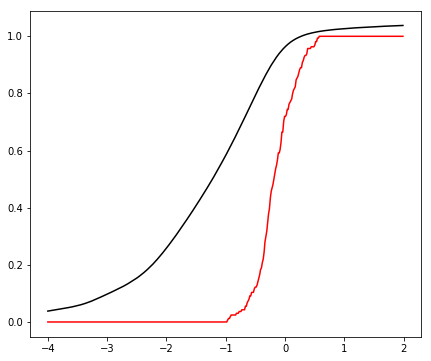


****************************************
Minimizer is Linear
Chi2                      =  1.65957e+10
NDf                       =        24749
p0                        =      0.02937   +/-   0.00999056  
p1                        =    -0.172619   +/-   0.00065991  
raw 99: 0.170  95: -0.055  90: -0.220  01: -4.000  05: -3.655
bg 99: 0.545  95: 0.380  90: 0.290  01: -0.955  05: -0.670


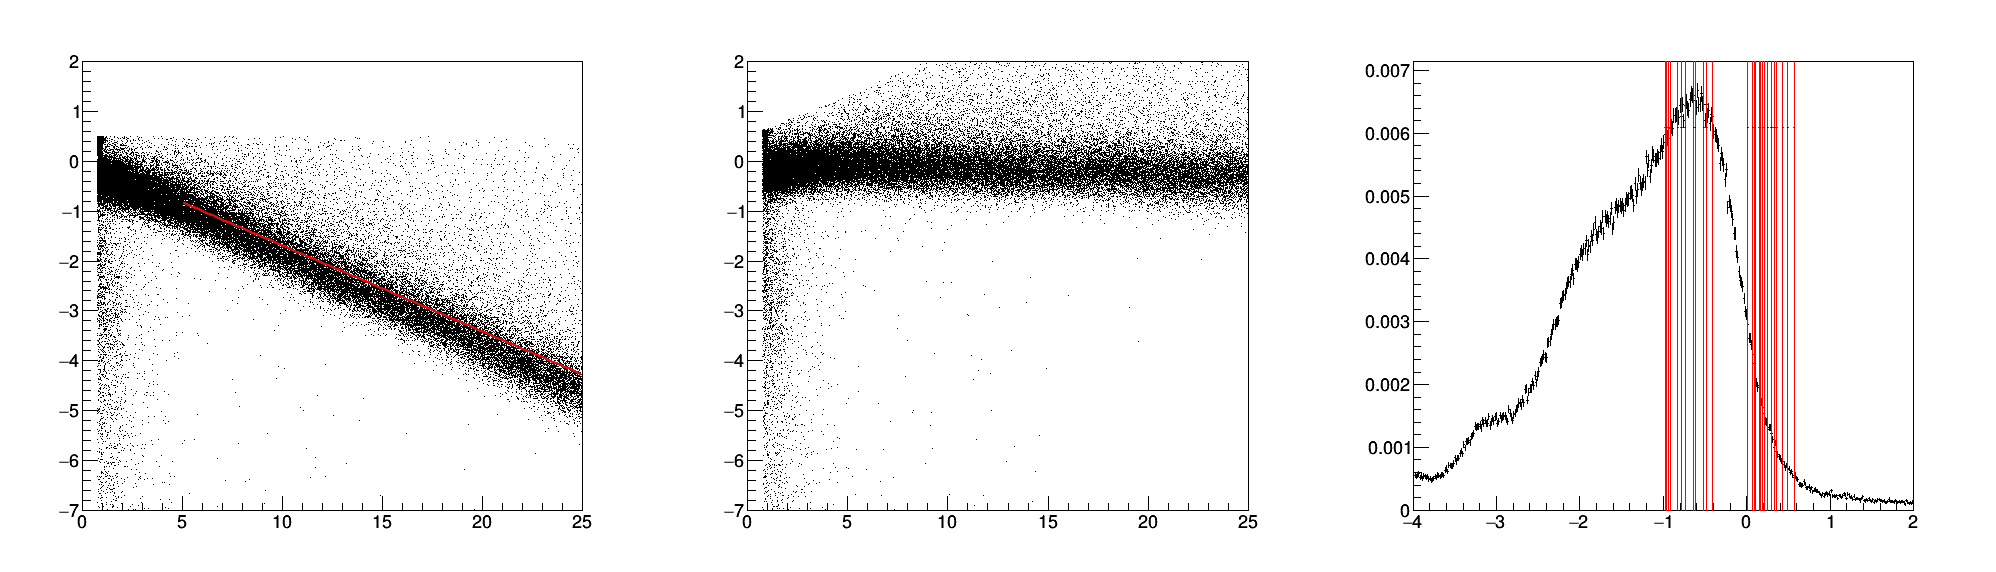

In [32]:
ds = 1
bins, lower, upper = 400,-4,2

f1 = ROOT.TFile("~/project/lat/latSkimDS%d_0_0.root"%ds)
theCut = f1.Get("theCut").GetTitle()
bgCut = "&& isNat && trapENFCal > 9.8 && trapENFCal < 10.8" # Integrating over 10.4 keV peak
ExtCut = "channel == 624"
calib = ROOT.TChain("skimTree"); calib.Add("~/project/cal-lat/latSkimDS%d*.root"%ds)
bg = ROOT.TChain("skimTree"); bg.Add("~/project/lat/latSkimDS%d*.root"%ds)

c = ROOT.TCanvas("c","c",2000,600)
c.Divide(3,1)
c.cd(1) 

# make the raw spectrum
ROOT.gPad.SetLogy(0)
xBins, xBinL, xBinH = 100, 0, 25
yBins, yBinL, yBinH = 10000, -7, 2
xStr, yStr = 'trapENFCal', 'trapETailMin'
h1 = ROOT.TH2D("h1","",xBins,xBinL,xBinH,yBins,yBinL,yBinH); calib.Project("h1",yStr+":"+xStr,theCut)
h1.Draw()
form1 = ROOT.TF1("form1","pol1",5,25)
h1.Fit("form1", "RL")

c.cd(2); ROOT.gPad.SetLogy(0); ROOT.gPad.SetLogx(0)
p0, p1 = form1.GetParameter(0), form1.GetParameter(1)

h2 = ROOT.TH2D("h2","",xBins,xBinL,xBinH,yBins,yBinL,yBinH)
calib.Project("h2","(trapETailMin-%f-%f*trapENFCal):trapENFCal"%(p0,p1),theCut)
h2.Draw()

c.cd(3)
h0 = ROOT.TH1D("h0","",bins,lower,upper)
h01 = ROOT.TH1D("h01","",bins,lower,upper)
calib.Project("h0","(trapETailMin-%f-%f*trapENFCal)"%(p0,p1), theCut+"&& trapENFCal > 10")
bg.Project("h01","(trapETailMin-%f-%f*trapENFCal)"%(p0,p1),theCut+bgCut)
h0.Scale(1/h0.Integral()); h0.SetLineColor(ROOT.kBlack); h0.Draw()
h01.Scale(1/h01.Integral()); h01.SetLineColor(ROOT.kRed); h01.Draw("SAME")
c.Draw()

# # Direct integral method
raw01,raw05,raw10,raw15,raw90,raw95,raw99 = GetIntegralPoints(h0)
bg01,bg05,bg10,bg15,bg90,bg95,bg99 = GetIntegralPoints(h01)
print "raw 99: %.3f  95: %.3f  90: %.3f  01: %.3f  05: %.3f" % (raw99,raw95,raw90,raw01,raw05)
print "bg 99: %.3f  95: %.3f  90: %.3f  01: %.3f  05: %.3f" % (bg99,bg95,bg90,bg01,bg05)

fig = plt.figure(figsize=(7,6),facecolor='w')
x_h0, y_h0 = npTH1D(h0,lower,upper)
int_h0 = integFunc(y_h0)
plt.plot(x_h0,int_h0,'black')
x1_h0, y1_h0 = npTH1D(h01,lower,upper)
int1_h0 = integFunc(y1_h0)
plt.plot(x1_h0,int1_h0,'red')
plt.show()

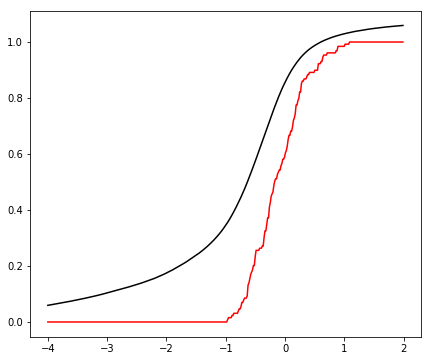


****************************************
Minimizer is Linear
Chi2                      =  1.82638e+10
NDf                       =        28164
p0                        =    0.0310804   +/-   0.00919919  
p1                        =    -0.178146   +/-   0.000608305 
raw 99: 0.530  95: 0.290  90: 0.110  01: -4.000  05: -4.000
bg 99: 1.010  95: 0.650  90: 0.560  01: -0.955  05: -0.745


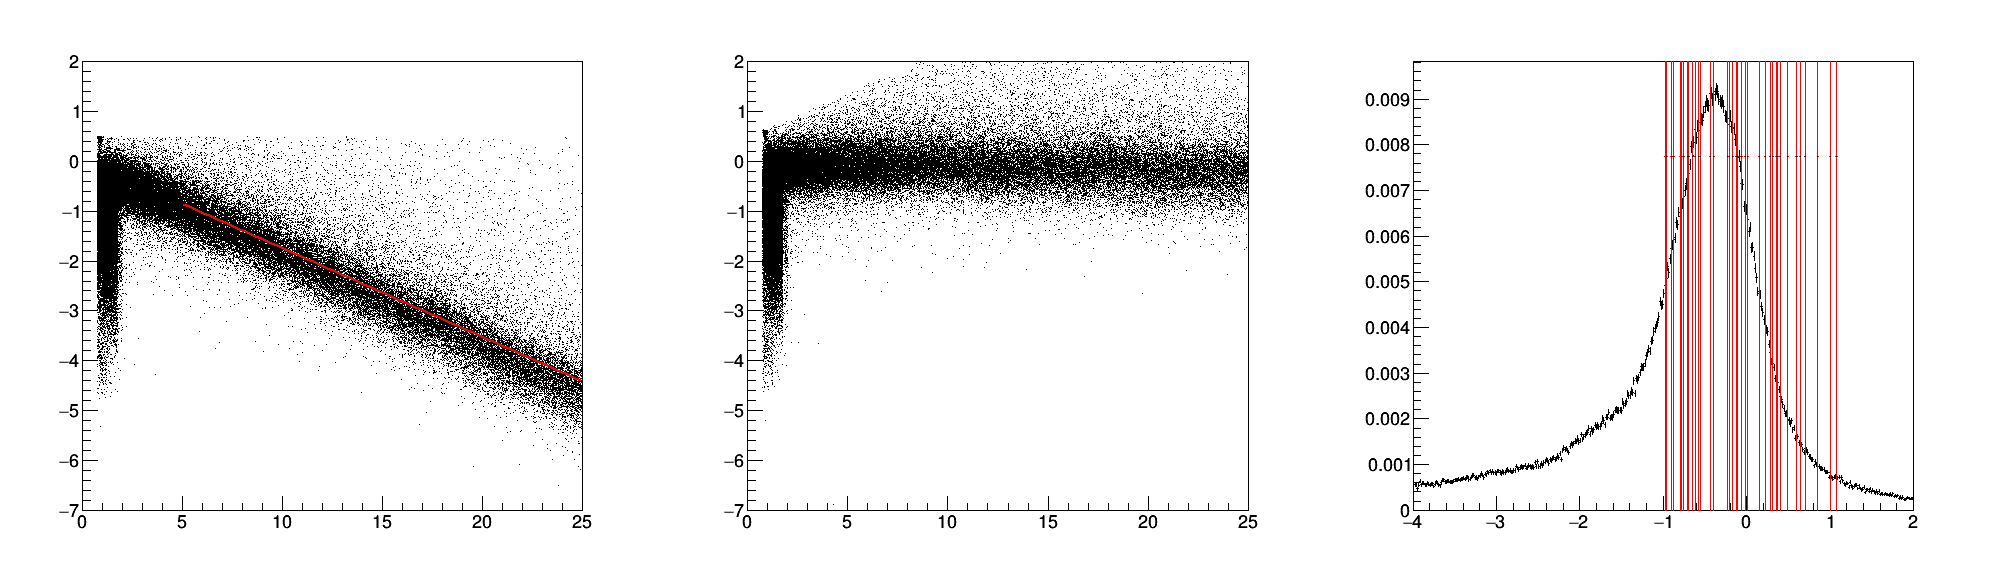

In [33]:
ds = 3
bins, lower, upper = 400,-4,2

f1 = ROOT.TFile("~/project/lat/latSkimDS%d_0_0.root"%ds)
theCut = f1.Get("theCut").GetTitle()
bgCut = "&& isNat && trapENFCal > 9.8 && trapENFCal < 10.8" # Integrating over 10.4 keV peak
ExtCut = "channel == 624"
calib = ROOT.TChain("skimTree"); calib.Add("~/project/cal-lat/latSkimDS%d*.root"%ds)
bg = ROOT.TChain("skimTree"); bg.Add("~/project/lat/latSkimDS%d*.root"%ds)

c = ROOT.TCanvas("c","c",2000,600)
c.Divide(3,1)
c.cd(1) 

# make the raw spectrum
ROOT.gPad.SetLogy(0)
xBins, xBinL, xBinH = 100, 0, 25
yBins, yBinL, yBinH = 10000, -7, 2
xStr, yStr = 'trapENFCal', 'trapETailMin'
h1 = ROOT.TH2D("h1","",xBins,xBinL,xBinH,yBins,yBinL,yBinH); calib.Project("h1",yStr+":"+xStr,theCut)
h1.Draw()
form1 = ROOT.TF1("form1","pol1",5,25)
h1.Fit("form1", "RL")

c.cd(2); ROOT.gPad.SetLogy(0); ROOT.gPad.SetLogx(0)
p0, p1 = form1.GetParameter(0), form1.GetParameter(1)

h2 = ROOT.TH2D("h2","",xBins,xBinL,xBinH,yBins,yBinL,yBinH)
calib.Project("h2","(trapETailMin-%f-%f*trapENFCal):trapENFCal"%(p0,p1),theCut)
h2.Draw()

c.cd(3)
h0 = ROOT.TH1D("h0","",bins,lower,upper)
h01 = ROOT.TH1D("h01","",bins,lower,upper)
calib.Project("h0","(trapETailMin-%f-%f*trapENFCal)"%(p0,p1), theCut+"&& trapENFCal > 10")
bg.Project("h01","(trapETailMin-%f-%f*trapENFCal)"%(p0,p1),theCut+bgCut)
h0.Scale(1/h0.Integral()); h0.SetLineColor(ROOT.kBlack); h0.Draw()
h01.Scale(1/h01.Integral()); h01.SetLineColor(ROOT.kRed); h01.Draw("SAME")
c.Draw()

# # Direct integral method
raw01,raw05,raw10,raw15,raw90,raw95,raw99 = GetIntegralPoints(h0)
bg01,bg05,bg10,bg15,bg90,bg95,bg99 = GetIntegralPoints(h01)
print "raw 99: %.3f  95: %.3f  90: %.3f  01: %.3f  05: %.3f" % (raw99,raw95,raw90,raw01,raw05)
print "bg 99: %.3f  95: %.3f  90: %.3f  01: %.3f  05: %.3f" % (bg99,bg95,bg90,bg01,bg05)

fig = plt.figure(figsize=(7,6),facecolor='w')
x_h0, y_h0 = npTH1D(h0,lower,upper)
int_h0 = integFunc(y_h0)
plt.plot(x_h0,int_h0,'black')
x1_h0, y1_h0 = npTH1D(h01,lower,upper)
int1_h0 = integFunc(y1_h0)
plt.plot(x1_h0,int1_h0,'red')
plt.show()

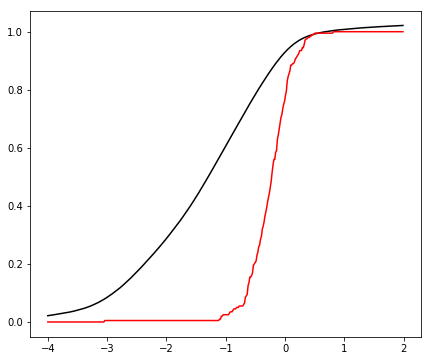


****************************************
Minimizer is Linear
Chi2                      =  2.59914e+10
NDf                       =        34501
p0                        =     0.027181   +/-   0.0084785   
p1                        =    -0.169388   +/-   0.000565247 
raw 99: 0.470  95: 0.110  90: -0.115  01: -4.000  05: -3.340
bg 99: 0.455  95: 0.320  90: 0.170  01: -1.075  05: -0.775


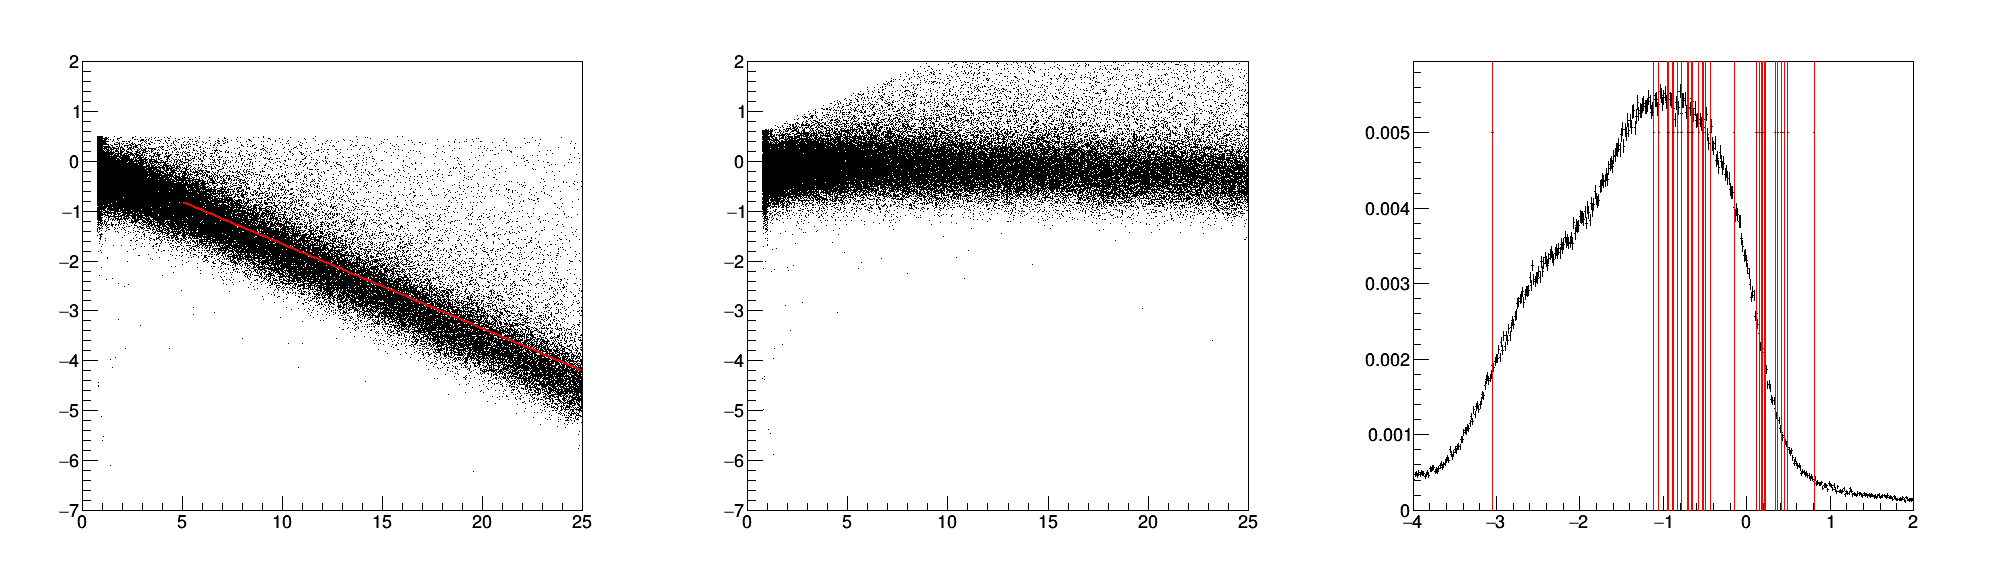

In [34]:
ds = 4
bins, lower, upper = 400,-4,2

f1 = ROOT.TFile("~/project/lat/latSkimDS%d_0_0.root"%ds)
theCut = f1.Get("theCut").GetTitle()
bgCut = "&& isNat && trapENFCal > 9.8 && trapENFCal < 10.8" # Integrating over 10.4 keV peak
ExtCut = "channel == 624"
calib = ROOT.TChain("skimTree"); calib.Add("~/project/cal-lat/latSkimDS%d*.root"%ds)
bg = ROOT.TChain("skimTree"); bg.Add("~/project/lat/latSkimDS%d*.root"%ds)

c = ROOT.TCanvas("c","c",2000,600)
c.Divide(3,1)
c.cd(1) 

# make the raw spectrum
ROOT.gPad.SetLogy(0)
xBins, xBinL, xBinH = 100, 0, 25
yBins, yBinL, yBinH = 10000, -7, 2
xStr, yStr = 'trapENFCal', 'trapETailMin'
h1 = ROOT.TH2D("h1","",xBins,xBinL,xBinH,yBins,yBinL,yBinH); calib.Project("h1",yStr+":"+xStr,theCut)
h1.Draw()
form1 = ROOT.TF1("form1","pol1",5,25)
h1.Fit("form1", "RL")

c.cd(2); ROOT.gPad.SetLogy(0); ROOT.gPad.SetLogx(0)
p0, p1 = form1.GetParameter(0), form1.GetParameter(1)

h2 = ROOT.TH2D("h2","",xBins,xBinL,xBinH,yBins,yBinL,yBinH)
calib.Project("h2","(trapETailMin-%f-%f*trapENFCal):trapENFCal"%(p0,p1),theCut)
h2.Draw()

c.cd(3)
h0 = ROOT.TH1D("h0","",bins,lower,upper)
h01 = ROOT.TH1D("h01","",bins,lower,upper)
calib.Project("h0","(trapETailMin-%f-%f*trapENFCal)"%(p0,p1), theCut+"&& trapENFCal > 10")
bg.Project("h01","(trapETailMin-%f-%f*trapENFCal)"%(p0,p1),theCut+bgCut)
h0.Scale(1/h0.Integral()); h0.SetLineColor(ROOT.kBlack); h0.Draw()
h01.Scale(1/h01.Integral()); h01.SetLineColor(ROOT.kRed); h01.Draw("SAME")
c.Draw()

# # Direct integral method
raw01,raw05,raw10,raw15,raw90,raw95,raw99 = GetIntegralPoints(h0)
bg01,bg05,bg10,bg15,bg90,bg95,bg99 = GetIntegralPoints(h01)
print "raw 99: %.3f  95: %.3f  90: %.3f  01: %.3f  05: %.3f" % (raw99,raw95,raw90,raw01,raw05)
print "bg 99: %.3f  95: %.3f  90: %.3f  01: %.3f  05: %.3f" % (bg99,bg95,bg90,bg01,bg05)

fig = plt.figure(figsize=(7,6),facecolor='w')
x_h0, y_h0 = npTH1D(h0,lower,upper)
int_h0 = integFunc(y_h0)
plt.plot(x_h0,int_h0,'black')
x1_h0, y1_h0 = npTH1D(h01,lower,upper)
int1_h0 = integFunc(y1_h0)
plt.plot(x1_h0,int1_h0,'red')
plt.show()

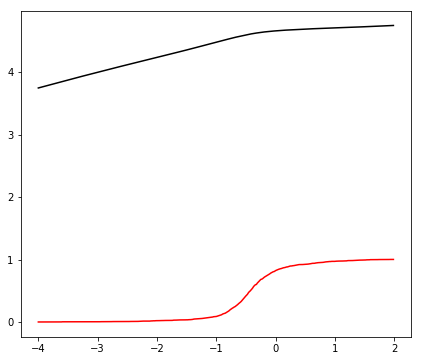


****************************************
Minimizer is Linear
Chi2                      =  1.46136e+11
NDf                       =        54643
p0                        =    -0.167158   +/-   0.0124791   
p1                        =    -0.130094   +/-   0.000823507 
raw 99: -4.000  95: -4.000  90: -4.000  01: -4.000  05: -4.000
bg 99: 1.325  95: 0.680  90: 0.245  01: -3.325  05: -1.390


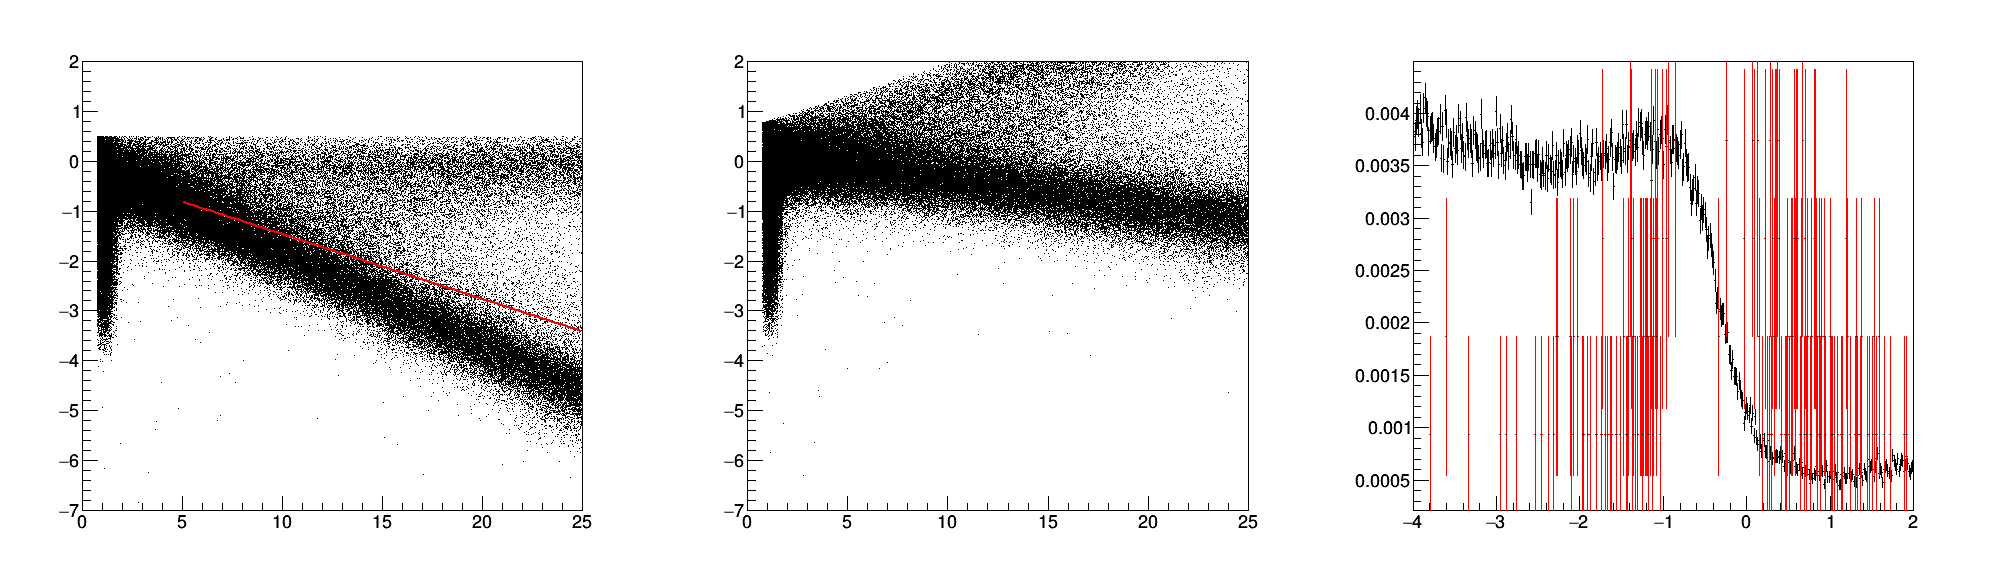

In [35]:
ds = 5
bins, lower, upper = 400,-4,2

f1 = ROOT.TFile("~/project/lat/latSkimDS%d_0_0.root"%ds)
theCut = f1.Get("theCut").GetTitle()
bgCut = "&& isNat && trapENFCal > 9.8 && trapENFCal < 10.8" # Integrating over 10.4 keV peak
ExtCut = "channel == 624"
calib = ROOT.TChain("skimTree"); calib.Add("~/project/cal-lat/latSkimDS%d*.root"%ds)
bg = ROOT.TChain("skimTree"); bg.Add("~/project/lat/latSkimDS%d*.root"%ds)

c = ROOT.TCanvas("c","c",2000,600)
c.Divide(3,1)
c.cd(1) 

# make the raw spectrum
ROOT.gPad.SetLogy(0)
xBins, xBinL, xBinH = 100, 0, 25
yBins, yBinL, yBinH = 10000, -7, 2
xStr, yStr = 'trapENFCal', 'trapETailMin'
h1 = ROOT.TH2D("h1","",xBins,xBinL,xBinH,yBins,yBinL,yBinH); calib.Project("h1",yStr+":"+xStr,theCut)
h1.Draw()
form1 = ROOT.TF1("form1","pol1",5,25)
h1.Fit("form1", "RL")

c.cd(2); ROOT.gPad.SetLogy(0); ROOT.gPad.SetLogx(0)
p0, p1 = form1.GetParameter(0), form1.GetParameter(1)

h2 = ROOT.TH2D("h2","",xBins,xBinL,xBinH,yBins,yBinL,yBinH)
calib.Project("h2","(trapETailMin-%f-%f*trapENFCal):trapENFCal"%(p0,p1),theCut)
h2.Draw()

c.cd(3)
h0 = ROOT.TH1D("h0","",bins,lower,upper)
h01 = ROOT.TH1D("h01","",bins,lower,upper)
calib.Project("h0","(trapETailMin-%f-%f*trapENFCal)"%(p0,p1), theCut+"&& trapENFCal > 10")
bg.Project("h01","(trapETailMin-%f-%f*trapENFCal)"%(p0,p1),theCut+bgCut)
h0.Scale(1/h0.Integral()); h0.SetLineColor(ROOT.kBlack); h0.Draw()
h01.Scale(1/h01.Integral()); h01.SetLineColor(ROOT.kRed); h01.Draw("SAME")
c.Draw()

# # Direct integral method
raw01,raw05,raw10,raw15,raw90,raw95,raw99 = GetIntegralPoints(h0)
bg01,bg05,bg10,bg15,bg90,bg95,bg99 = GetIntegralPoints(h01)
print "raw 99: %.3f  95: %.3f  90: %.3f  01: %.3f  05: %.3f" % (raw99,raw95,raw90,raw01,raw05)
print "bg 99: %.3f  95: %.3f  90: %.3f  01: %.3f  05: %.3f" % (bg99,bg95,bg90,bg01,bg05)

fig = plt.figure(figsize=(7,6),facecolor='w')
x_h0, y_h0 = npTH1D(h0,lower,upper)
int_h0 = integFunc(y_h0)
plt.plot(x_h0,int_h0,'black')
x1_h0, y1_h0 = npTH1D(h01,lower,upper)
int1_h0 = integFunc(y1_h0)
plt.plot(x1_h0,int1_h0,'red')
plt.show()